In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing.image import img_to_array
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Chec GPU Support
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500\\data\\images")

In [9]:
CROP_SIZE = 300
UPSCALE_FACTOR = 3
INPUT_SIZE = CROP_SIZE // UPSCALE_FACTOR

In [14]:
def load_data(path, resolution):
    # Load the images
    images = []
    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(path, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, resolution)
            img = img.astype('float32') / 255.0
            images.append(img_to_array(img))
    return np.array(images)

In [16]:
input_res = (INPUT_SIZE, INPUT_SIZE)
output_res = (CROP_SIZE, CROP_SIZE)

x_train = load_data(root_dir + '\\train', input_res)
y_train = load_data(root_dir + '\\train', output_res)

x_test = load_data(root_dir + '\\test', input_res)
y_test = load_data(root_dir + '\\test', output_res)

print("Train input loaded with shape: {}".format(x_train.shape))
print("Train output loaded with shape: {}".format(y_train.shape))
print("Test input loaded with shape: {}".format(x_test.shape))
print("Test output loaded with shape: {}".format(y_test.shape))

Train input loaded with shape: (200, 100, 100, 3)
Train output loaded with shape: (200, 300, 300, 3)
Test input loaded with shape: (200, 100, 100, 3)
Test output loaded with shape: (200, 300, 300, 3)


(-0.5, 299.5, 299.5, -0.5)

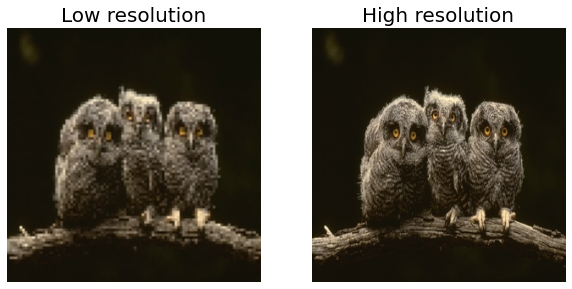

In [28]:
a = np.random.randint(0, len(x_train))
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(x_train[a])
plt.title("Low resolution", fontsize=20)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y_train[a])
plt.title("High resolution", fontsize=20)
plt.axis('off')

In [57]:
INPUT_SHAPE = (INPUT_SIZE, INPUT_SIZE, 3)

# Hiperparameters
BATCH_SIZE = 1
LEARNING_RATE = 0.001
EPOCHS = 200
PATIENCE = 10
MIN_DELTA = 0.001
RESTORE = True
DROPOUT = 0.3

conv_args = {
    "activation": "relu",
    "kernel_initializer": "Orthogonal",
    "padding": "same",
}

# Model definition
model = keras.Sequential([
    layers.Input(shape=INPUT_SHAPE),
    layers.UpSampling2D(size=(UPSCALE_FACTOR, UPSCALE_FACTOR)),
    layers.Conv2D(64, 5, **conv_args),
    layers.Conv2D(64, 5, **conv_args),
    layers.Conv2D(32, 3, **conv_args),
    layers.Conv2D(3, 3, **conv_args),
])

# Model compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=keras.losses.MeanSquaredError(), metrics=['acc'])
model.summary()

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=PATIENCE, restore_best_weights=RESTORE)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_8 (UpSampling  (None, 300, 300, 3)      0         
 2D)                                                             
                                                                 
 conv2d_38 (Conv2D)          (None, 300, 300, 64)      4864      
                                                                 
 conv2d_39 (Conv2D)          (None, 300, 300, 64)      102464    
                                                                 
 conv2d_40 (Conv2D)          (None, 300, 300, 32)      18464     
                                                                 
 conv2d_41 (Conv2D)          (None, 300, 300, 3)       867       
                                                                 
Total params: 126,659
Trainable params: 126,659
Non-trainable params: 0
________________________________________________

Training

In [58]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/200
200/200 [==============================] - 4s 20ms/step - loss: 0.0102 - acc: 0.6944 - val_loss: 0.0042 - val_acc: 0.8761
Epoch 2/200
200/200 [==============================] - 4s 19ms/step - loss: 0.0044 - acc: 0.8583 - val_loss: 0.0052 - val_acc: 0.8485
Epoch 3/200
200/200 [==============================] - 4s 19ms/step - loss: 0.0050 - acc: 0.8372 - val_loss: 0.0039 - val_acc: 0.8941
Epoch 4/200
200/200 [==============================] - 4s 20ms/step - loss: 0.0037 - acc: 0.9066 - val_loss: 0.0038 - val_acc: 0.9100
Epoch 5/200
200/200 [==============================] - 4s 20ms/step - loss: 0.0040 - acc: 0.9034 - val_loss: 0.0042 - val_acc: 0.8347
Epoch 6/200
200/200 [==============================] - 4s 20ms/step - loss: 0.0039 - acc: 0.8821 - val_loss: 0.0038 - val_acc: 0.9214
Epoch 7/200
200/200 [==============================] - 4s 20ms/step - loss: 0.0044 - acc: 0.8903 - val_loss: 0.0062 - val_acc: 0.7150
Epoch 8/200
200/200 [==============================] - 4s 20ms

In [46]:
# Save weights
# model.save_weights("upscaler_v3.h5")

# Load weights
# model.load_weights("upscaler_v1.h5")

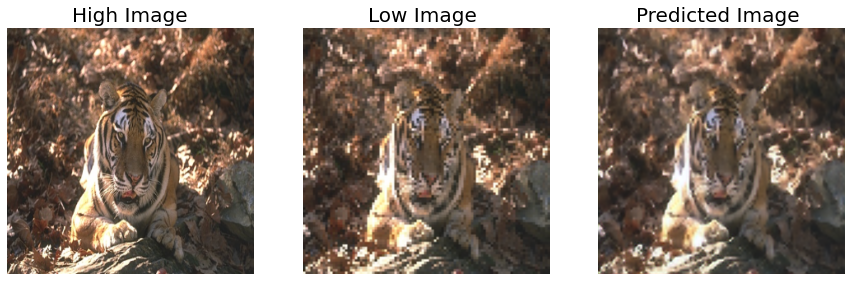

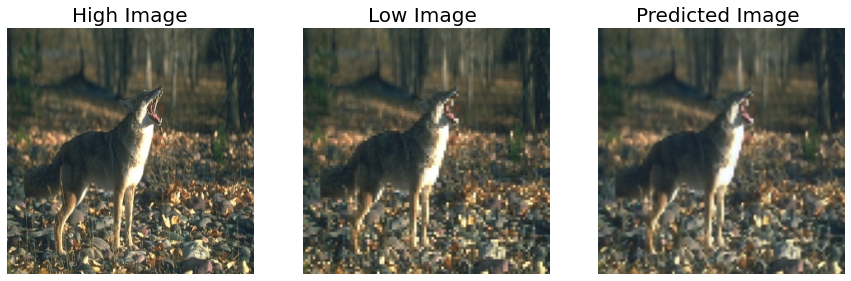

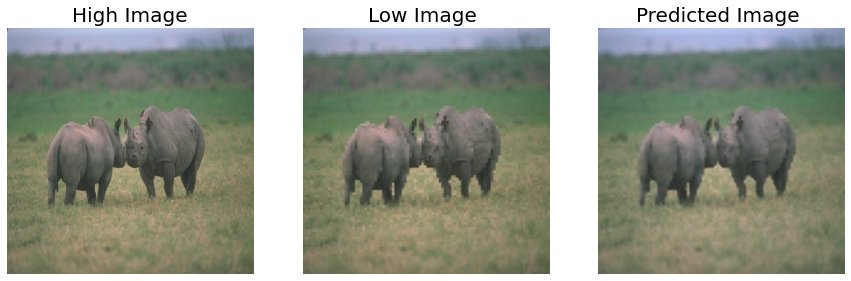

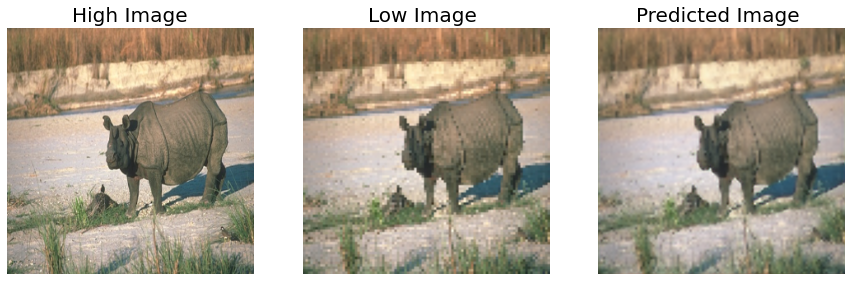

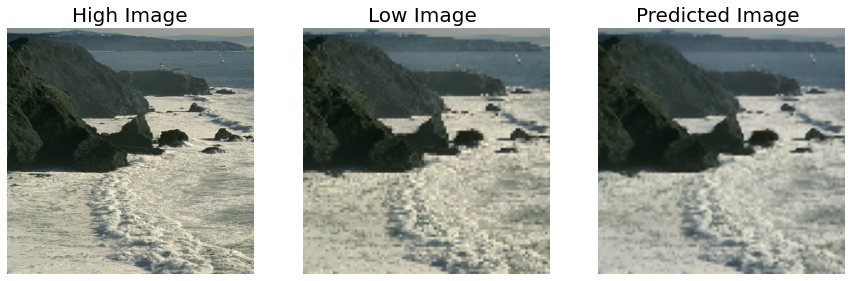

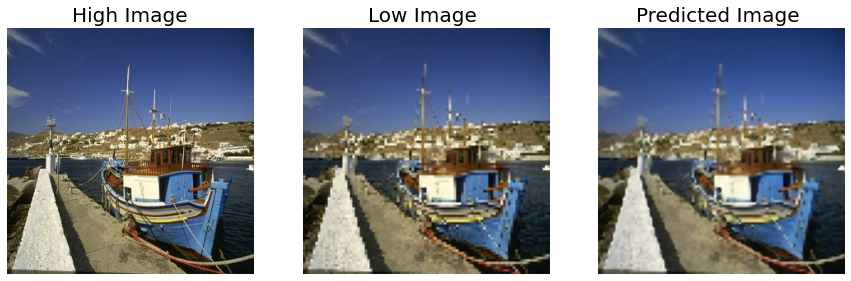

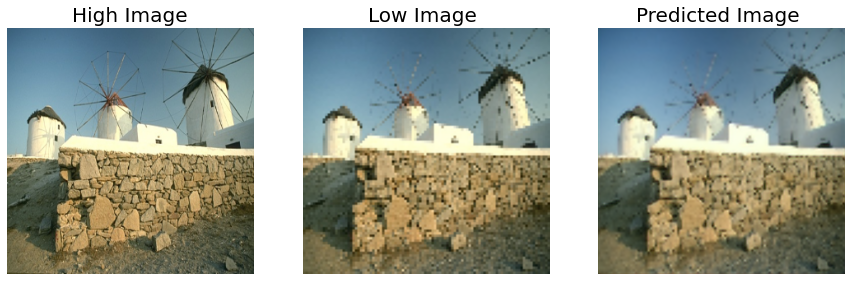

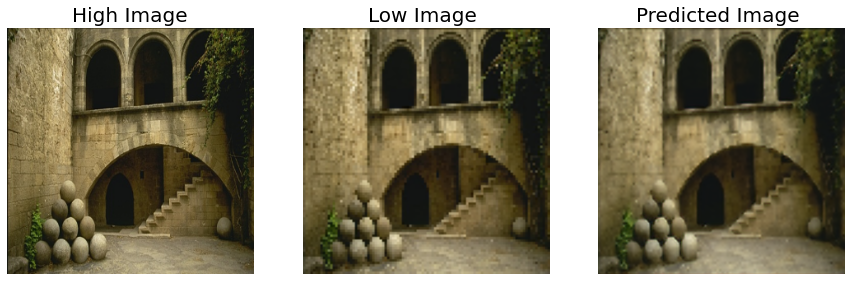

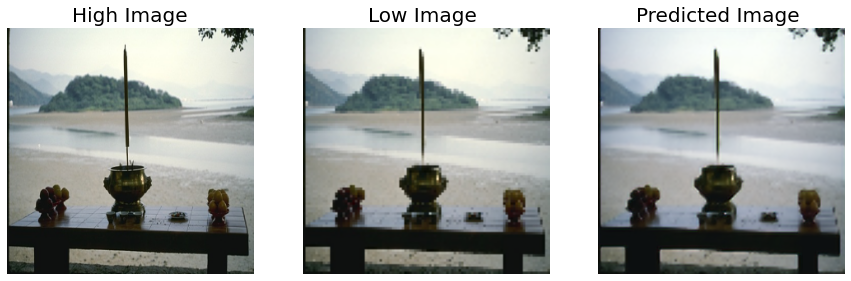

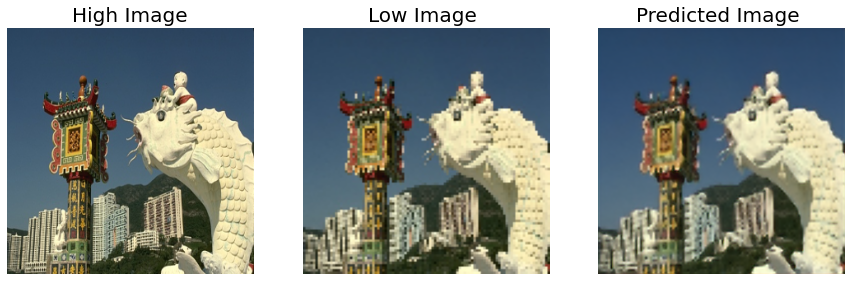

In [59]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', fontsize = 20)
    plt.axis('off')
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', fontsize = 20)
    plt.axis('off')
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', fontsize = 20)
    plt.axis('off')
    plt.imshow(predicted)
   
    plt.show()

for i in range(20, 30):
    predicted = np.clip(model.predict(x_test[i].reshape(1,100,100,3)),0.0,1.0).reshape(300,300,3)
    plot_images(y_test[i],x_test[i],predicted)